In [18]:
from lib.data import Mimic2
import numpy as np
from lib.model import LR
from lib.train import Trainer, prepareData
from torch.utils.data import Dataset, DataLoader, TensorDataset
from lib.regularization import eye_loss
from sklearn.metrics import accuracy_score
from lib.utility import get_y_yhat, model_auc
import torch
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from main import random_risk_exp, expert_feature_only_exp, diff_regs_exp
import glob
from sklearn.externals import joblib
from pandas import DataFrame

# MIMIC2 

We use MIMIC2 dataset to predict mortality.

data preprocess:
1. For each time series, we compute the mean, min, and max
2. We use the features of scores in Jean-roger et al. (A simplified acute physiology score for ICU patients) as $r$
3. standardize each feature to have zero mean and unit variance

We are using physionet 2012 challenge with no test set. We use a stratified random split of the trianing data for seta data. Our result on both AUC and score1 is comparable to other published results (each model is train for 300 epoch).

In [2]:
m = Mimic2(mode='total', expert_feature_only=False)

In [3]:
m.x

,ALP_max,ALP_mean,ALP_min,ALT_max,ALT_mean,ALT_min,AST_max,AST_mean,AST_min,Age,...,HR_worst,K_worst,MechVent_worst,NISysABP_worst,Na_worst,RespRate_worst,SysABP_worst,Temp_worst,Urine_worst,WBC_worst
0,111.344379,104.634113,98.294675,222.427077,171.741809,120.289367,348.2,240.465689,143.786667,54.0,...,58.000000,4.400000,12.0,157.000000,137.0,12.000000,115.134094,35.100000,2470.000000,11.2
1,111.344379,104.634113,98.294675,222.427077,171.741809,120.289367,348.2,240.465689,143.786667,76.0,...,80.000000,4.300000,49.0,122.469331,139.0,21.725615,66.000000,34.500000,3474.000000,7.4
2,127.000000,116.000000,105.000000,91.000000,83.000000,75.000000,235.0,199.500000,164.000000,44.0,...,57.000000,8.600000,49.0,150.000000,137.0,21.725615,115.134094,39.000000,2910.000000,3.7
3,105.000000,105.000000,105.000000,12.000000,12.000000,12.000000,15.0,15.000000,15.000000,68.0,...,57.000000,4.000000,12.0,102.000000,140.0,12.000000,115.134094,35.100000,1400.000000,8.8
4,111.344379,104.634113,98.294675,222.427077,171.741809,120.289367,348.2,240.465689,143.786667,88.0,...,67.000000,6.000000,12.0,156.000000,140.0,26.000000,115.134094,35.800000,1196.000000,3.8
5,101.000000,101.000000,101.000000,60.000000,52.500000,45.000000,162.0,104.500000,47.000000,64.0,...,71.000000,3.800000,49.0,73.000000,137.0,21.725615,115.134094,35.800000,2850.000000,24.0
6,111.344379,104.634113,98.294675,222.427077,171.741809,120.289367,348.2,240.465689,143.786667,68.0,...,50.000000,3.400000,12.0,218.000000,139.0,11.000000,115.134094,35.800000,1366.000000,6.2
7,47.000000,47.000000,47.000000,46.000000,46.000000,46.000000,82.0,82.000000,82.000000,78.0,...,62.000000,3.900000,49.0,122.469331,141.0,21.725615,76.000000,35.600000,973.000000,20.4
8,111.344379,104.634113,98.294675,222.427077,171.741809,120.289367,348.2,240.465689,143.786667,64.0,...,120.000000,3.900000,12.0,106.000000,139.0,44.000000,115.134094,36.800000,700.000000,15.2
9,111.344379,104.634113,98.294675,222.427077,171.741809,120.289367,348.2,240.465689,143.786667,74.0,...,67.000000,4.600000,49.0,122.469331,141.0,21.725615,78.000000,34.800000,2610.000000,9.0


In [4]:
r = Variable(torch.FloatTensor(list(map(lambda name: 1 if 'worst' in name else 0, m.x.columns))))

d = r.size(0)
train_data = TensorDataset(*map(lambda x: x.data, prepareData(m.xtrain, m.ytrain)))
data = DataLoader(train_data, batch_size=4000, shuffle=True)

valdata = TensorDataset(*map(lambda x: x.data, prepareData(m.xval, m.yval)))
valdata = DataLoader(valdata, batch_size=4000, shuffle=True)

n_output = 2 # binary classification task                                                                                                                                          
model = LR(d, n_output)                                                                                                                                                            
learning_rate = 0.001                                                                                                                                                               

reg_parameters = model.i2o.weight
t = Trainer(model, lr=learning_rate, risk_factors=r, alpha=0.0, # 0.01 for eye
            regularization=eye_loss, reg_parameters=reg_parameters)  
losses, vallosses = t.fit(data, n_epochs=10, print_every=1, valdata=valdata)                                                                                                                                                       

def model_acc(model, x, y):                                                                                                                                                        
    x, _ = prepareData(x, y)                                                                                                                                                       
    yhat = np.argmax(model(x).data.numpy(), 1)                                                                                                                                     
    return accuracy_score(y, yhat)                                                                                                                                                 

print('train auc', model_auc(model, data) )
print('val auc', model_auc(model, valdata)) 

10.00% (0m 0s) 0.0003 0.44160.4458
20.00% (0m 0s) 0.0003 0.45060.4565
30.00% (0m 0s) 0.0003 0.45990.4670
40.00% (0m 0s) 0.0003 0.46970.4764
50.00% (0m 1s) 0.0003 0.48010.4884
60.00% (0m 1s) 0.0003 0.49100.4999
70.00% (0m 1s) 0.0003 0.50160.5117
80.00% (0m 1s) 0.0003 0.51270.5224
90.00% (0m 1s) 0.0003 0.52370.5323
100.00% (0m 1s) 0.0003 0.53410.5427
train auc 0.534067304385
val auc 0.542673850917


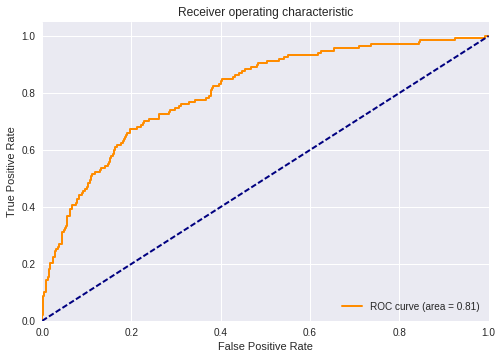

In [108]:
from lib.utility import plotAUC
plotAUC(m, model, valdata)

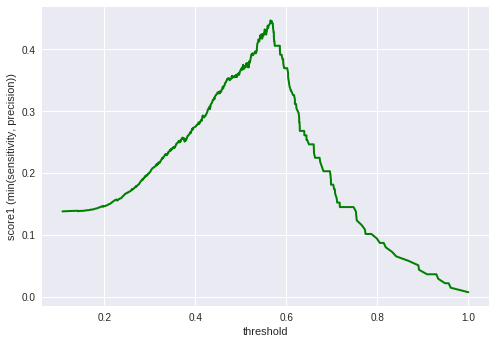

score1 on validation set is 0.446808510638


In [11]:
from lib.utility import sweepS1

threshold, score1 = sweepS1(model, valdata, plot=True, mode='s1')
print('score1 on validation set is', score1)

In [8]:
from sklearn.metrics import average_precision_score

def calcAP(ytrue, ypred):
    return average_precision_score(ytrue, np.abs(ypred))

ap = calcAP(r.data.numpy(), (reg_parameters[1] - reg_parameters[0]).data.numpy())
print('average precision is', ap)

average precision is 0.114624900322


In [495]:
print('average precision is %.4f' % calcAP(r.data.numpy(), (reg_parameters[1] - reg_parameters[0]).data.numpy()))
print('val auc is %.4f' % model_auc(model, valdata)) 

average precision is 0.2074
val auc is 0.7996


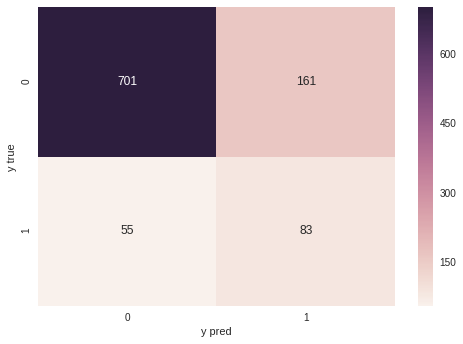

In [463]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_test, y_score = get_y_yhat(model, valdata)
yhat = np.argmax(y_score, 1)
cm = confusion_matrix(y_test, yhat)
sns.heatmap(cm, annot=True, fmt='d')
sns.set(font_scale=1)
plt.ylabel('y true')
plt.xlabel('y pred')
plt.show()
tn, fp, fn, tp = cm.ravel()

In [217]:
print(m.ytrain.sum() / m.ytrain.shape[0])
print(m.yval.sum() / m.yval.shape[0])

0.138666666667
0.138


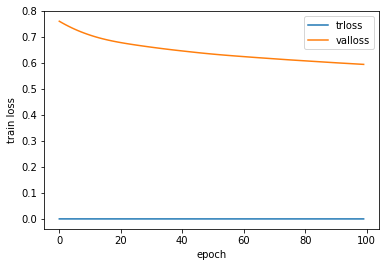

In [302]:
import matplotlib.pyplot as plt
begin = 0
end = 3000
plt.plot(losses[begin:end], label='trloss')
plt.plot(vallosses[begin:end], label='valloss')
plt.legend()

plt.ylabel('train loss')
plt.xlabel('epoch')
plt.show()

We compute the same statistics as for Cdiff. 

Observations:
1. expert only ridge logistic regression performs considerably worse than other methods (0.74 vs ~0.81)
2. random feature eye has a large AP while maintaining a good auc means that almost all features of size 16 has comparable predictive power
3. of all high auc method, eye has the highest sparsity

In [72]:
diff_regs_exp()

0.33% (0m 0s) 0.0003 0.50050.4373
0.67% (0m 0s) 0.0003 0.51560.4517
1.00% (0m 0s) 0.0003 0.53040.4647
1.33% (0m 0s) 0.0003 0.54460.4772
1.67% (0m 0s) 0.0003 0.55770.4880
2.00% (0m 0s) 0.0003 0.57000.4984
2.33% (0m 0s) 0.0003 0.58130.5088
2.67% (0m 0s) 0.0003 0.59240.5189
3.00% (0m 0s) 0.0003 0.60270.5284
3.33% (0m 0s) 0.0003 0.61250.5386
3.67% (0m 1s) 0.0003 0.62200.5484
4.00% (0m 1s) 0.0003 0.63110.5584
4.33% (0m 1s) 0.0003 0.63970.5683
4.67% (0m 1s) 0.0003 0.64800.5784
5.00% (0m 1s) 0.0003 0.65620.5884
5.33% (0m 1s) 0.0003 0.66400.5980
5.67% (0m 1s) 0.0003 0.67160.6084
6.00% (0m 1s) 0.0003 0.67890.6187
6.33% (0m 1s) 0.0003 0.68590.6283
6.67% (0m 1s) 0.0003 0.69230.6378
7.00% (0m 1s) 0.0002 0.69850.6465
7.33% (0m 1s) 0.0002 0.70460.6557
7.67% (0m 2s) 0.0002 0.71070.6646
8.00% (0m 2s) 0.0002 0.71640.6734
8.33% (0m 2s) 0.0002 0.72190.6821
8.67% (0m 2s) 0.0002 0.72720.6909
9.00% (0m 2s) 0.0002 0.73200.6992
9.33% (0m 2s) 0.0002 0.73680.7063
9.67% (0m 2s) 0.0002 0.74110.7136
10.00% (0m 2s)

# show result

In [77]:
raw_data = []
for fn in glob.glob('models/*.pkl'):
    name = fn.split('/')[1].split('.pkl')[0]    
    name, alpha = name.split('^')
    if 'test' in name: name = name[4:]+'*'
    auc, ap, s1, sp = joblib.load(fn)
    raw_data.append([name, alpha, auc, ap, s1, sp])
df = DataFrame(data=raw_data, columns=['method name', 'alpha', 'auc', 'ap', 'min(recall, precision)', 'sparsity'])

In [78]:
df.sort_values(['method name', 'alpha'])

,method name,alpha,auc,ap,"min(recall, precision)",sparsity
34,enet,0.0001,0.839069,0.174890,0.423077,0.045802
43,enet,0.001,0.842567,0.184739,0.442308,0.160305
47,enet,0.01,0.852599,0.124615,0.485714,0.595420
21,enet,0.1,0.806502,0.092175,0.490385,0.893130
13,enet,1e-05,0.838444,0.173252,0.423077,0.045802
8,enet*,0.01,0.811628,0.114064,0.413043,0.603053
33,expert_only_ridge,0.0001,0.696252,1.000000,0.326923,0.000000
25,expert_only_ridge,0.001,0.696446,1.000000,0.326923,0.000000
14,expert_only_ridge,0.01,0.698068,1.000000,0.320755,0.000000
23,expert_only_ridge,0.1,0.709053,1.000000,0.317308,0.000000


In [67]:
df.sort_values(['auc'], ascending=False)

,method name,alpha,auc,ap,"min(recall, precision)",sparsity
2,lasso*,0.01,0.818403,0.125262,0.434783,0.732824
7,wlasso*,0.001,0.815772,0.160819,0.435714,0.412214
3,eye_loss*,0.001,0.813074,0.203901,0.420290,0.381679
1,enet*,0.01,0.811628,0.114064,0.413043,0.603053
0,random_risk_eye*,0.001,0.807719,0.204315,0.410072,0.404580
4,wridge*,0.01,0.807298,0.237961,0.427673,0.068702
6,owl*,0.01,0.794899,0.120962,0.413043,0.022901
5,expert_only_ridge*,0.1,0.740744,1.000000,0.357143,0.000000


# Non-linear Credibility

The key to interpretable machine learning

1. output layer should be interpretable
2. output layer parameters should have low entropy (each explanation instance should be as general as possible)

thus we have the following optimization function (denote $z$ as explanation)

$cost(x) = \mathbb{E}_{z \sim p(z|x)} loss(x, z) + \alpha \mathcal{H}(z) = \mathbb{E}_{z \sim p(z|x)} \{loss(x, z) - \alpha p(z|x) \log p(z|x)\}$
 
where $x$ is the input of the network and $\mathcal{H}(z)$ is entropy and $alpha>0$ is tradeoff parameter

Based on this design guideline, we propose the following generalized linear interpretable model:

TODO: put a graph here

The model has two components, the switch network and the weight network, parametrized by $\theta_s$ and $\theta_w$ respectively.

The switch network takes in $x$ and output $p(z|x) = \Pi_{k=1}^K p(z_k|x)$ (here assumes naive bayes, we can extend later using rnn)

We can have analytical solution in this case (see derivation on my phone)